# Micromagnetic model

## Mesh

In [1]:
import oommfc as oc

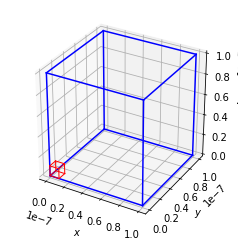

In [2]:
%matplotlib inline
L = 100e-9
d = 10e-9
mesh = oc.Mesh(p1=(0, 0, 0), p2=(L, L, L), cell=(d, d, d), name="mesh")
mesh

The domain edge lengths in x, y, and z directions are:

In [3]:
mesh.l

(1e-07, 1e-07, 1e-07)

The number of cells in all three directions:

In [4]:
mesh.n

(10, 10, 10)

The centre point of the mesh:

In [5]:
mesh.centre

(5e-08, 5e-08, 5e-08)

## System

The basic block of our micromagnetic model is the system object. It is fully defined if:

1. Hamiltonian,
2. dynamics equation,
3. magnetisation.

are provided. The system is then "driven" in phase space using particular drivers.

In [6]:
system = oc.System(name="system")

## Hamiltonian

In [7]:
exchange = oc.Exchange(A=1e-12)

In [8]:
exchange

Exchange(A=1e-12, name="exchange")

In [9]:
exchange.A

1e-12

In [10]:
repr(exchange)

'Exchange(A=1e-12, name="exchange")'

In [11]:
hamiltonian = exchange + oc.Zeeman(H=(1e6, 0, 0))

type(hamiltonian)

oommfc.hamiltonian.hamiltonian.Hamiltonian

In [12]:
system.hamiltonian = hamiltonian

In [13]:
system.hamiltonian

Exchange(A=1e-12, name="exchange") + Zeeman(H=(1000000.0, 0, 0), name="zeeman")

In [14]:
system.hamiltonian.exchange.A

1e-12

In [15]:
system.hamiltonian.zeeman.H

(1000000.0, 0, 0)

In [16]:
system.hamiltonian += oc.Demag(name="energy_term_name")

In [17]:
system.hamiltonian.energy_term_name

Demag(name="energy_term_name")

## Dynamics

In [18]:
system.dynamics = oc.Precession(gamma=2.211e5) + oc.Damping(alpha=0.1)

In [19]:
system.dynamics

Precession(gamma=221100.0, name="precession") + Damping(alpha=0.1, name="damping")

## Magnetisation

In [20]:
import discretisedfield as df

In [21]:
Ms = 8e5
m = df.Field(mesh, value=(1, 0, 1), norm=Ms, name="m")

In [22]:
p = (50e-9, 50e-9, 5e-9)
m(p)  # sampling

(565685.42494923796, 0.0, 565685.42494923796)

In [23]:
m.f = lambda pos: (pos[0]+pos[2]+1, pos[2], 0)

In [24]:
system.m = m

## Drivers

### MinDriver

In [25]:
md = oc.MinDriver()
md.drive(system)

2017/9/25 14:38: Calling OOMMF (system/system.mif) ... [0.6s]


In [26]:
system.m.average

(796387.73365267611, -4.2200554162263867e-12, -0.00040380816577817311)

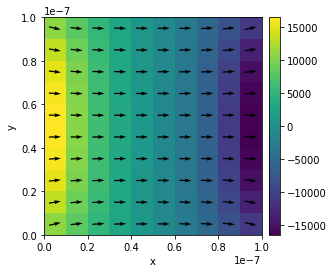

In [27]:
system.m.plot_plane("z")

In [28]:
system.hamiltonian.zeeman.H = (0, 1e7, 0)

In [29]:
md.drive(system)

2017/9/25 14:38: Calling OOMMF (system/system.mif) ... [0.6s]


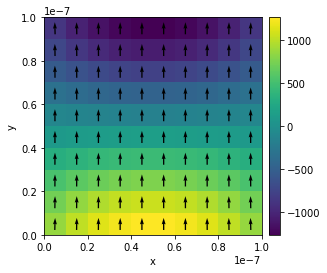

In [30]:
system.m.plot_plane("z")

### Time driver

In [31]:
system.hamiltonian += oc.UniaxialAnisotropy(K1=5e3, u=(0, 0, 1))
system.hamiltonian.zeeman.H = (1e6, 0, 0)

In [32]:
td = oc.TimeDriver()
td.drive(system, t=0.2e-9, n=50)

2017/9/25 14:39: Calling OOMMF (system/system.mif) ... [1.0s]


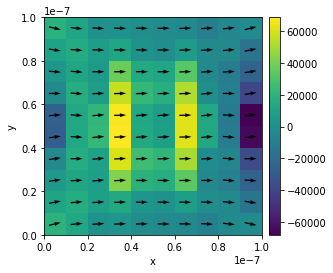

In [33]:
system.m.plot_plane("z")

In [34]:
system.dt

,E,Ecount,max_dm/dt,dE/dt,deltaE,E_Exchange,max_spin_angle,stage_max_spin_angle,run_max_spin_angle,E_Zeeman,E_Demag,E_UniaxialAnisotropy,iteration,stage_iteration,stage,mx,my,mz,last_time_step,t
0,4.937978e-17,49.0,15504.169456,-2.199822e-05,-3.014085e-17,2.434921e-20,5.843010,5.843010,5.843010,-8.571958e-17,1.329931e-16,2.081906e-18,8.0,8.0,0.0,0.085267,0.635764,0.762966,1.365857e-12,4.000000e-12
1,-3.745400e-17,62.0,15355.073463,-2.135642e-05,-4.007768e-17,6.193981e-20,10.194041,10.194041,10.194041,-1.715614e-16,1.336715e-16,3.739732e-19,11.0,2.0,1.0,0.170655,-0.174363,0.961511,1.860994e-12,8.000000e-12
2,-1.210936e-16,75.0,15475.885770,-2.045376e-05,-3.639889e-17,7.732737e-20,15.015990,15.015990,15.015990,-2.616382e-16,1.366673e-16,3.800002e-18,14.0,2.0,2.0,0.260256,-0.827733,0.475004,1.762302e-12,1.200000e-11
3,-2.011240e-16,88.0,15054.641932,-1.954275e-05,-3.291024e-17,1.013508e-19,16.748167,16.748167,16.748167,-3.440782e-16,1.384426e-16,4.410329e-18,17.0,2.0,3.0,0.342261,-0.870443,-0.316834,1.666791e-12,1.600000e-11
4,-2.770202e-16,101.0,14069.762967,-1.835674e-05,-3.243005e-17,1.405714e-19,19.713938,19.713938,19.713938,-4.130360e-16,1.344386e-16,1.436607e-18,20.0,2.0,4.0,0.410854,-0.304328,-0.842589,1.740225e-12,2.000000e-11
5,-3.478000e-16,114.0,13129.912239,-1.703618e-05,-2.758906e-17,1.513495e-19,20.389262,20.897681,20.897681,-4.818787e-16,1.317493e-16,2.178021e-18,23.0,2.0,5.0,0.479334,0.433170,-0.745181,1.594995e-12,2.400000e-11
6,-4.133816e-16,127.0,12642.331456,-1.574731e-05,-2.518676e-17,1.894826e-19,17.674614,20.389262,20.897681,-5.510081e-16,1.326767e-16,4.760248e-18,26.0,2.0,6.0,0.548098,0.805275,-0.136522,1.573383e-12,2.800000e-11
7,-4.733437e-16,140.0,11522.221837,-1.417117e-05,-2.140401e-17,2.957435e-19,18.096429,18.096429,20.897681,-6.074985e-16,1.302324e-16,3.626618e-18,29.0,2.0,7.0,0.604290,0.577910,0.499801,1.477491e-12,3.200000e-11
8,-5.266426e-16,153.0,11135.846711,-1.252402e-05,-1.799357e-17,3.928615e-19,20.508025,20.508025,20.897681,-6.584845e-16,1.289977e-16,2.451356e-18,32.0,2.0,8.0,0.655007,-0.014985,0.708063,1.406479e-12,3.600000e-11
9,-5.740128e-16,166.0,11413.875436,-1.120847e-05,-1.514981e-17,4.764423e-19,22.945438,22.945438,22.945438,-7.113419e-16,1.328580e-16,3.994594e-18,35.0,2.0,9.0,0.707585,-0.504395,0.402317,1.327369e-12,4.000000e-11


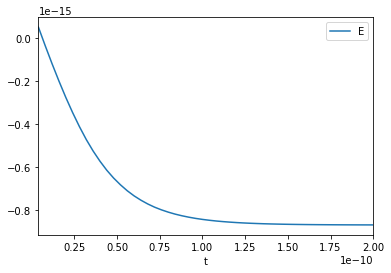

In [35]:
system.dt.plot("t", "E")